# ADVANCED STATISTICS FOR PHYSICS ANALYSIS

## K2 algorithm implementation in R

Marco Agnolon, 1205461

Andrea Perin, 1206078

Carlo Polato, 1205688

Tommaso Tabarelli, 1205459

### Table of contents<a class="anchor" id="toc"></a>


* [Theoretical introduction](#lol)
    - [Bayesian networks](#bn)
    - [Computing the structure](#struct)
    - [Assumptions for the computation of the structure](#ass)
    - [Notation and the basic theorem](#theo)
    - [Implications in practice](#imply)
    - [The K2 algorithm](#algo)
    - [Proposed pseudocode](#pseudo)
    
* [Code implementation](#code)
    - [A proposed variant](#powerset)
    - [A possible modification for large datasets](#stirling)

#### Bayesian networks <a class="anchor" id="bn"></a>

Bayesian belief networks are a class of networks which can be used to perform inference on a set of observables. The network structure allows the implementation of dependencies among different observables, so that correlations can become apparent, and the extraction of possible causation mechanisms becomes easier.

Bayesian belief networks are computed starting from a dataset $D$, containing a number $m$ of entries, each of them being made up of $n$ features. For each feature pair, a question one may ask is: "what is the probablity that, given a certain value, $v_{1i}$, of feature $x_1$, feature $x_2$ has the  value $v_{2j}$?" This may be particularly interesting in the case of a medical database, as to highlight possible dependencies between symptoms.
This amounts to calculating the conditional probability
$$
P(x_2=v_{2j}|x_1=v_{1i}),
$$
which is what inference is all about: calculating probabilities given a certain degree of prior knowledge. 
From a more formal point of view, a Bayesian belief network is a pair $B=(B_S,B_P)$ of the two following objects:
- a Bayesian belief structure, $B_S$;
- a set of conditional probabilities between the various nodes, $B_P$.

#### $B_S$
A Bayesian belief network structure $B_S$ is a directed acyclic graph (DAG) in which nodes represent domain variables (i.e., the features in the database) and edges between nodes represent probabilistic dependencies between said variables. A variable in a Bayesian belief network may be either discrete or continuous; however, in the following, only the discrete case will be treated.

In [1]:
#install.packages("igraph")
library("igraph")


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



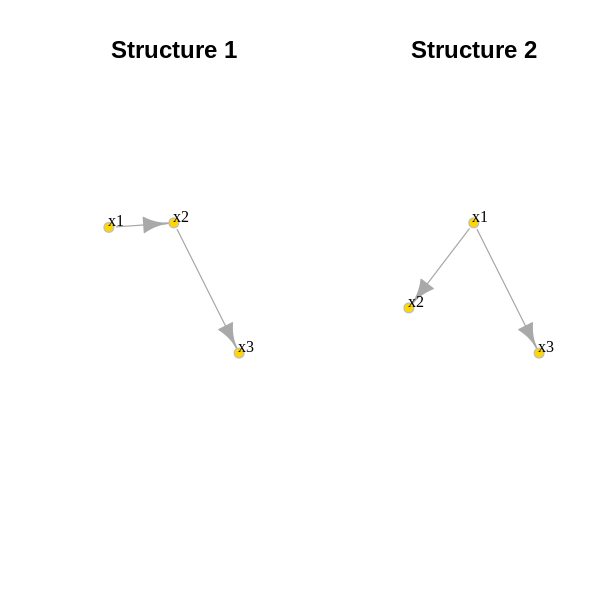

In [2]:
library(repr)
options(repr.plot.width=5, repr.plot.height=5)
par(mfrow=c(1,2))
g1 <- graph( edges=c("x1","x2", "x2","x3") )
plot(g1, main="Structure 1",edge.arrow.size=1.75, vertex.color="gold", vertex.size=15, 
     vertex.frame.color="gray", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=2)

g2 <- graph( edges=c("x1","x2", "x1","x3") )
plot(g2, main="Structure 2", edge.arrow.size=1.75, vertex.color="gold", vertex.size=15, 
     vertex.frame.color="gray", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=2)

Above are two examples of two possible structures for a network of $n=3$ features (nodes). In the first graph, the directed structure implies that, **given the knowledge of the value of node $x_2$, node $x_3$ is independent of the value of $x_1$**. This simple example is enough to show that directed acyclic graphs are able to represent conditional dependencies (and also independencies). Obviously, if the value of $x_2$ was not fixed, then $x_3$ would certainly depend on $x_1$.

#### $B_P$
For each node in the belief structure $B_S$, there is a conditional-probability function relating it to its immediate predecessor, which are called its *parents*. Given a node $X_i$, the set of its parents is denoted by $\pi_i$. The probability of a particular value being assigned to node $x_i$ will then be dependent on the values taken by the set $\pi_i$ (also called *instantiation*). If a given node $x_i$ has no parents, then a prior probability $P(x_i)$ is defined.

$B_P$ is the set of all conditional probabilities that are defined over a Bayesian belief structure $B_S$. Adding a set $B_P$ to a structure $B_S$ yields a proper Bayesian belief network $B$.

#### $B$
A fundamental property of Bayesian belief networks is their ability of representing the probabilities over any discrete sample space, that is, **the probability of any sample point in the sample space can be calculated starting from the probabilities in the belief network**. Let $\{C_1, C_2, ... , C_n\}$ be the set of the domains of the $n$ features in a Bayesian belief networks; then, denoting by $X_i$ one particular value that node $x_i$ can take (so that $X_i \in C_i, \hspace{1em} \forall i$; this is called an *instantiation*), we have that the probability $P(X_1, X_2, ... , X_n)$ of the instantiation of all the $n$ nodes can be computed starting from the conditional probabilities in the belief network.

More specifically, it can be shown that
$$
P(X_1, X_2, ... , X_n)= \prod_{i=1}^{n} P(X_i|\pi_i)
$$
where $\pi_i$ represents the instantiation of the parents of node $x_i$. This means that the joint probability of all nodes can be computed as a product of $n$ probabilities. 
By exhausting all possible instantiations (by trying out all possible combinations of values) we can compute what the joint-probability space looks like.

[Back to ToC](#toc)

#### Computing the structure<a class="anchor" id="struct"></a>
While all of this sounds straightforward enough, a major problem resides in the structure $B_S$ one should employ. That is: given a dataset of $m$ entries and $n$ features, how do we decide the corresponding structure? In the figure above, is Structure 1 more or less probable than Structure 2?

Let $D$ be a database of cases, $Z$ be the set of variables represented by $D$ (so that $|Z|=n$ in the notation used before), and $B_{S_i}$ and $B_{S_j}$ be two possible structures containing exactly those variables that are in $Z$. Our concern is to calculate the ratio
$$
P(B_{S_i}|D)/P(B_{S_j}|D)
$$
We can write the following

$$
\frac{P(B_{S_i}|D)}{P(B_{S_j}|D)} = \frac{\frac{P(B_{S_i},D)}{P(D)}}{\frac{P(B_{S_j},D)}{P(D)}}=\frac{P(B_{S_i},D)}{P(B_{S_j},D)}
$$

There exists a method for computing the quantity $P(B_S,D)$ where $B_S$ is an arbitrary belief network structure, given some assumptions.

[Back to ToC](#toc)

#### Assumptions for the computation of $P(B_S,D)$<a class="anchor" id="ass"></a>
There are 4 main assumptions one has to make in order to render the computation feasible:

1. **The database variables, which we denote as Z, are discrete;**
    * We can calculate the probability of a certain structure $B_S$ and a database $D$ as
    $$
    P(B_S,D)=\int_{B_P} P(D|B_S, B_P)f(B_P|B_S)P(B_S) dB_P
    $$
    where $B_P$ is a vector containing all the possible conditional-probability assignments associated with a particular belief-network $B_S$ (this is a finite-dimensional entity, which is at most $\frac{n(n-1)}{2}$ elements long), and $f(B_P|B_S)$ is the conditional-probability density function of $B_P$ given $B_S$. The assumption of discrete variables allow us to use the probability mass function $P(D|B_S, B_P)$ instead of the density $f(D|B_S, B_P)$.The integration takes place over all possible value assignments to $B_P$. All of this means we are integrating over all possible belief networks having structure $B_S$.
    * As an example, let $B_S$ be Structure 1 above. Then, let $B_P'$ be one particular set (a table) of numeric probability values for a network with Structure 1. Integrating over $B_P$ would equate varying the numbers in the table in all possible ways that are consistent with the axioms of probability. The term $f(B_P|B_S)$ denotes the likelihood of observing the particular set of numerical values $B_P'$ given the Structure 1. Finally, $P(D|B_S, B_P')$ represents the probability of observing the entries in the database, given Structure 1 and the particular set of conditional probabilities. 
    * The term $P(B_S)$ can be seen as a way of introducing inductive bias in the algorithm, as it denotes a prior distribution over the possible structures. 
2. **Realizations of the features occur independently, given a belief-network model;**
    * This assumption is simply stating that the choice of a model does not impact the actual data distribution. When this holds, we can factorize the term $P(D|B_S, B_P)$ as
    $$
    P(D|B_S, B_P)=\prod_{h=1}^{m}P(C_h|B_S,B_P)
    $$
    so that in the end we get
    $$
    P(B_S,D)=\int_{B_P} \left[ \prod_{h=1}^{m}P(C_h|B_S,B_P) \right]f(B_P|B_S)P(B_S) dB_P
    $$
    where, as in the previous notation, $m$ is the number of entries i the dataset $D$, and $C_h$ denotes the $h$-the entry in the dataset.
3. **There are no realizations with missing values;**
    * Which is generally not valid for real-world datasets.
4. **The density function $f(B_P|B_S)$ in equations above is uniform.**
    * This assumption states that, before observing $D$, we are indifferent with respect to the numerical probabilities to associate to structures $B_S$. This simply means that, taking once again Structure 1 as an example, before taking a look at the dataset, $P(x1=v_{1i}|x2=v_{2j})$ is equally likely to be equal to 0.6 or equal to 0.3 (or any other value in the interval [0,1], for that matter).
    
[Back to ToC](#toc)

#### Notation and the basic theorem<a class="anchor" id="theo"></a>

We now define some notation that will be used extensively in the following.

- the parents of a node $x_i$ are represented by a list (a vector) of variables, which we denote as $\pi_i$;
- the $j$-th unique instantiation of the values of the variables in $\pi_i$ will be denoted $w_{ij}$; we will say that $w_{ij}$ is a *value* or an *instantiation* of $\pi_i$;
- $r_i$ is the number of unique values that a (discrete!) variable $x_i$ in $Z$ can take;
- $q_i$ is the number of unique instantiations of $\pi_i$;


We can now present the following 

**Theorem**:

- Let $Z$ be a set of $n$ discrete variables, where a variable $x_i\in Z$ has $r_i$ possible distinct value assignments $(v_{i1}, ... , v_{ir_i})$;
- Let $D$ be a database of $m$ entries, where each entry contains a value for each one of the $n$ variables in $Z$;
- Let $B_S$ denote a belief structure containing just the variables in $Z$; each variable in $Z$ has a set of parents we denote as $\pi_i$;
- Let $W_{ij}$ denote the $j$-th unique instantiation of $\pi_i$ relative to $D$;
- Suppose there are $q_i$ such unique instantiations of $\pi_i$; 
- Define $N_{ijk}$ as the number of entries in $D$ in which variable $x_i$ has the value $v_{ik}$ and and $\pi_i$ is instantiated as $w_{ij}$;
- Let then 
$$
N_{ij} = \sum_{k=1}^{r_i} N_{ijk}.
$$
**Then:**
$$
P(B_S,D)=P(B_S) \prod_{i=1}^{n}\prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} N_{ijk}!
$$

[Back to ToC](#toc)

#### Implications in practice<a class="anchor" id="imply"></a>

**This theorem provides a way of comparing the probabilities of different structures, and thus, by applying it over all possible structures, we can find the "best possible structure" (in terms of probability).**
This is certainly nice. However, it can be shown that the number of possible belief structures for a set of $n$ nodes follows the following recursice equation:
$$
\begin{cases}
f(2)=3,\\
f(n)=\sum_{i=1}^n (-1)^{i+1} {n \choose i} 2^{i(n-i)} f(n-i)
\end{cases}
$$
which has the following behavior:

- $f(2)=3$;
- $f(3)=25$;
- $f(5)=29000$;
- $f(10) \approx 4.2\times 10^{18}$.

Computing all structures is not feasible. Then we need some heuristic procedure to allow finding the (heuristically) most probable structure.

#### From exact methods to heuristcs
An important assumption from now on is the existence of some *ordering* on the $n$ nodes, such that if node $x_i$ come before node $x_j$ in the ordering, then $x_j$ will not be part of the potential parents of $x_i$. Given this ordering as constraint, there are $2^{n(n-1)/2}$ possible structures left, a number which is still untreatable with exact methods for large values of $n$. Let us then also include another assumption, that is, equal priors on the structures themselves. This results in the following:

$$
P(B_S,D)=c\prod_{i=1}^{n}\prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} N_{ijk}!
$$

where $c$ is simply the constant prior probability $P(B_S)$. We want to maximize this equation. To do so, **we only need to find the set of parents for each variable that maximizes the second inner product**:

$$
\max_{B_S}{P(B_S,D)}=c\prod_{i=1}^{n}\max_{\pi_i}\left[\prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} N_{ijk}!\right]
$$

where the maximization takes place over all possible sets of parents $\pi_i$ which are consistent with the ordering. This is where the K2 algorithm starts from.

[Back to ToC](#toc)

#### The K2 algorithm<a class="anchor" id="algo"></a>

We can now introduce the K2 algorithm, a heuristic approach that, starting from the maximization above, employs a greedy search.
In particular, K2 starts from the assumption that a node has no parents. Then, it incrementally adds those parents whose addition most increases the probability of the resulting structure. This is done by choosing possible parents from those consistent with the ordering. When the addition of no single parent can increase the probability, then no more parents are added, and the algorithm goes on to the next node in the ordering.
By introducing the functions

$$
g(i,\pi_i)=\prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!}\prod_{k=1}^{r_i}N_{ijk}!,
$$

and

$$
\text{Pred}(x_i),
$$

which returns the set of nodes that precede $x_i$ in the node ordering, we can write the K2 algorithm pseudocode as follows:

[Back to ToC](#toc)

#### Proposed pseudocode<a class="anchor" id="pseudo"></a>


`procedure K2`;

{**Input**: a set of $n$ nodes, and ordering on the nodes, an upper bound $u$ on the number of parents a node may have, and a database $D$ containing $m$ entries}

{**Output**: for each node, the set of its parents}

**for** $i:=0$ **to** $n$ **do**:

&ensp;&ensp;&ensp;&ensp;$\pi_i := \emptyset$;

&ensp;&ensp;&ensp;&ensp;$P_{old} := g(i, \pi_i)$;

&ensp;&ensp;&ensp;&ensp;OKToProceed $:=$ `TRUE`;

&ensp;&ensp;&ensp;&ensp;**while** OKToProceed & $|\pi_i|<u$ **do**

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;let $z$ be the node in $\{$Pred($x_i$)$\setminus \pi_i\}$ that maximizes $g(i, \pi_i \cup \{z\})$;

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$P_{new} := g(i, \pi_i \cup \{z\})$;

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;**if** $P_{new} > P_{old}$ **then**

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$P_{old} := P_{new}$;

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$\pi_i := \pi_i \cup \{z\}$;

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;**else** OKToProceed $:=$ `FALSE`; 

&ensp;&ensp;&ensp;&ensp;**end** $\{$while$\}$;

&ensp;&ensp;&ensp;&ensp;**write**(`Node:`,$x_i$,`Parents of this node:`,$\pi_i$);

**end**$\{$for$\}$;

**end**$\{$K2$\}$.

[Back to ToC](#toc)

### CODE IMPLEMENTATION<a class="anchor" id="code"></a>


[Back to ToC](#toc)

In [41]:
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3 <- c(0,1,1,1,0,1,1,0,1,0)
x4 <- c(1,1,0,0,1,1,1,0,1,1)



df = data.frame(x1,x2,x3, x4)
df

x1,x2,x3,x4
<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1
1,1,1,1
0,0,1,0
1,1,1,0
0,0,0,1
0,1,1,1
1,1,1,1
0,0,0,0
1,1,1,1


In [42]:
df <- df[,c(1,2,3,4)] # you can but the correct ordered selected
df

x1,x2,x3,x4
<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1
1,1,1,1
0,0,1,0
1,1,1,0
0,0,0,1
0,1,1,1
1,1,1,1
0,0,0,0
1,1,1,1


In [43]:
n <- ncol(df)
u <- 2 # maximum number of possible parents

r <- as.numeric(lengths(lapply(df, unique))) # number of unique values in each node
m <- as.numeric(lapply(df, length))  # number of values in each node
r.vec <- lapply(df, unique)  # which are the unique values for each node



uq_elem=list()

for(i in 1:n)
{
      uq_elem[[i]] <-  unlist(r.vec[i], use.names=F) # list that contains the values of the unique elements for each node

}


### function Nijk

In [44]:
N <- function(df, i, j, k, prec, u) { # i is the node, j the combination of previous values, k the value of node i 
    
    
    if(j==0){  # case without parents
        count <- length(which(df[,c(i)]==uq_elem[[i]][k])) 
            }
   
    if( (length(prec)==1)  &  (j!=0)){ # case with just one parent
        
                                                       
        count <- length(which(  (df[,c(i)]==uq_elem[[i]][k]) & (df[,c(prec)]==uq_elem[[prec]][j])  ))
        

        }
    
        
    if((length(prec)>=2) &  (j!=0)){ # case with two or more parents
        
        size <- length(prec)
        
        indices <- numeric(size)
        
        x <- j-1
        
        for (a in c(0:(size-2)) ){ 
            indices[size-a]<-(x%%r[prec[size-a]])+1 # the indices from last to second are given 
                                                    # by the remainder of the division +1
            x<-(x%/%r[prec[size-a]])
        }
        indices[1] <- x+1 # the first index is given by the result of the last division +1
        

        
        l0 <- which( (df[,c(i)]==uq_elem[[i]][k]) ) 
        h <- 1
        l <- list()

        for (node in prec){

            l[[h]] <- which( (df[,c(node)]==uq_elem[[node]][indices[h]]) )  

            h <- h+1
         }
        l[[length(l)+1]] <- l0
        
        count <- length(Reduce(intersect, l)) # intersection of list correspond to logic AND 
                                                # in the "one parent version"
        }
    
    
    return (count)
      
}

### function Nij

$$
N_{ij} = \sum_{k=1}^{r_i} N_{ijk}.
$$

In [45]:
N.sum <-function(df, i, j, prec, r, u) {
    
    c <- 0
    
    for (k in c(1:r[i])) {
         
        
         c <- c + N(df, i, j, k, prec, u)
        
        }
    
    return ( c )
    
    }


### function g

$$
g(i,\pi_i)=\prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!}\prod_{k=1}^{r_i}N_{ijk}!,
$$

In [46]:
product <-function(df, i, j, r, prec, u) {
    
    p <- 1
    
    for (k in c(1:r[i])){
            
            p<-p*factorial(N(df, i, j, k, prec, u))
            
        }
    
    return(p)
    }

In [47]:
g <-function(df, i, prec, r, u) {
    
    if (prec[1]==0){

        p <-  factorial(r[i]-1)/factorial(N.sum(df, i, 0, prec, r, u)+r[i]-1)*product(df, i, 0, r, prec, u)
            
    }
    
    if ((length(prec)==1)  &  (prec[1]!=0)){


        
        p <- 1
        
        for (j in c(1:r[prec[1]])){
            
            p<- p*factorial(r[i]-1)/factorial(N.sum(df, i, j, prec, r, u)+r[i]-1)*product(df, i, j, r, prec, u)
            
        }
        
    }
    
    if((length(prec)>=2) &  (prec[1]!=0)){

        size <- length(prec)
        
        
        p <- 1
        
        for (j in c(1:prod(r[prec])) ){
        
            
            p<- p*factorial(r[i]-1)/factorial(N.sum(df, i, j, prec, r, u)+r[i]-1)*product(df, i, j, r, prec, u)
           
        }
        
    }
    return (p)
    }

## K2

In [48]:
edges<-NULL 
for (i in c(1:n)){ # for node i in the list of nodes
    cat('node', paste(i),'\n')
    prec <- 0 # 0 means no parents
    P.old <- g(df, i, prec, r, u)
    #cat('P old 0 ',paste(P.old),'\n')
    OKtoProceed <- T
    
    if (i==1){ 
        OKtoProceed <- F    # if there are no parent nodes it does not enter the cycle
        }

    parents_set <- NULL     # the set of actual parents for each node
    all_possible_prec <- c(1:(i-1)) # the set of candidate parents for each node.
    
    num_parents <- 0    # initializing the number of parents for each node
    
    while ((OKtoProceed) & (num_parents < u)){
        
        change <- F    # boolean flag; set to true if an update happens
        max_test <- NULL  # the list of previously confirmed parents, plus the one which maximizes the probability
        
        for (ele in all_possible_prec){ # all_possible_prec is updated at the end of the while loop
            
            test <- c(parents_set, ele)  # test vector containing the confirmed parents plus onefrom the candidates
            
            P.new <- g(df, i, test, r, u) # the probability associated to test
            #cat('P new ',paste(P.new),'\n')
            if (P.new > P.old){  # maximizing P.new with respect to the candidates
                P.old <- P.new   # resetting P.old
                change <- T      # changing the flag to exit the cycle
                max_test <- test # setting the max as the specific instance of (parents+candidate)
            }
        }
        
        if (change){
            
            parents_set <- max_test  # the new parents_set becomes the union of the previous and the best candidate
            
            num_parents <- num_parents + 1 # a parent was added

            all_possible_prec <- c(1:(i-1)) # resetting all_possible_prec
            
            all_possible_prec <- all_possible_prec[-c(parents_set)] #removing confirmed parents from the candidates
        }
        
        if ((!change) | (length(all_possible_prec)==0)) { # if no change happened or if we run out of candidates
            OKtoProceed <- F # no further nodes can be added; no OkToProceed
        }

    }
    if (num_parents>0){
        cat('node', colnames(df)[parents_set] ,' parent of node', colnames(df)[i])
        for (index in parents_set){
                edges<-c(edges, colnames(df)[index])
                edges<-c(edges, colnames(df)[i])
                }
    }
    
    if (num_parents==0){
        cat('no node parent of node', colnames(df)[i])
    }
    
    cat('\n')
    
}



node 1 
no node parent of node x1
node 2 
node x1  parent of node x2
node 3 
node x2  parent of node x3
node 4 
no node parent of node x4


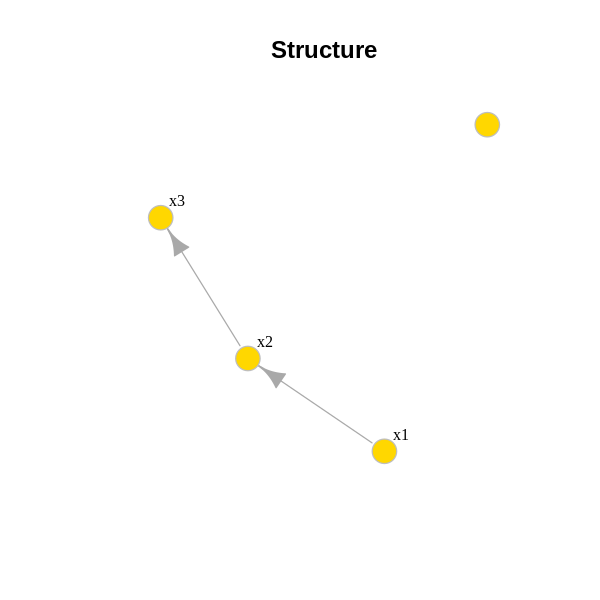

In [49]:
g1 <- graph( edges )

to_add<-NULL
for (i in c(1:(n))){
    if (!(colnames(df)[i] %in% edges))
        {
        to_add<-c(to_add, (colnames(df)[i]))
        }
}

g1<-add_vertices( g1, length(to_add), names=to_add )

plot(g1, main="Structure",edge.arrow.size=1.75, vertex.color="gold", vertex.size=15, 
     vertex.frame.color="gray", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=2)

### A proposed variant <a class="anchor" id="powerset"></a>

In the following, a possible variant of the K2 algorithm is implemented. The main difference is in the scope of the searched parents. For vanilla K2, finding the parents is based on an 'agglomerative' process; singular nodes are added one at a time, so that the previously confirmed parents are not modified by later additions. The proposed variant, instead, draws the set of parents from the powerset of the candidate parents; from iteration to iteration, the set of parents may change completely, depending on the 'aggregate performance' of that particular set, and not simply of a single added node. This results in a more thorough search, while being more computationally demanding.

[Back to ToC](#toc)

#### Powerset function


In [50]:
powerset <- function(set, u) {
    set<- set[set>0] # we want all numbers to be > 0
    
    len <- length(set)  
    masks <- 2^(1:len-1)   #this is an array of powers of 2, the length is the set's length, each of them can be written in base 2
    #using only one 1. The 1 is positioned every time in a different position so each of them represents a different 
    #number of the set
    pow <-lapply( 1:2^len-1, function(x) set[ bitwAnd(x, masks) != 0 ] )   
    # the bitwAnd make the logical operation And for each bit that make the two numbers and it returns the number that is created
    # in this case for each number from 0 to 2^len-1 it returns a list of boolean that represents the possible combinations of 
    # of things in the powerset
                 
    a<-list() 
    for (i in c(1:length(pow))){
        if ( (length(pow[[i]])>0) & (length(pow[[i]])<=u) ){  #it keeps only elements with length smaller or equal than u
            a[i] <- pow[i]
        }
       
    }
                 
    a <- a[-which(sapply(a, is.null))]
    return(a)
}
                 

In [51]:
edges<-NULL
for (i in c(1:n)){ # for node i in the list of nodes
    cat('node', paste(i),'\n')
    prec <- 0 # 0 means no parents
    x <- 0
    P.old <- g(df, i, prec, r, u)
    #cat('P old 0 ',paste(P.old),'\n')
    OKtoProceed <- T
    
    if (i==1){ 
        OKtoProceed <- F    # if there are no parent nodes it does not enter the cycle
        cat('no node parent of node', colnames(df)[i])

        }

    while ((OKtoProceed)){
        for (prec in powerset( c(1:(i-1))[], u )){ # pick one combinations of parents from the powerset 
            # "for c(1:(i-1)" ensure that we look for parents only on the previous columns of the dataframe
            
            P.new <- g(df, i, prec, r, u) 
            #cat('P new ',paste(P.new),'\n')
            if (P.new > P.old){
                P.old <- P.new    
                x <- prec
                }
        }   
        
        if(x[1]==0){
            cat('no node parent of node', colnames(df)[i])
        }
        
        if(x[1]!=0){
            cat('node', colnames(df)[x] ,' parent of node', colnames(df)[i])
            for (index in x){
                edges<-c(edges, colnames(df)[index])
                edges<-c(edges, colnames(df)[i])
                }
        }
        OKtoProceed <- F
        
    }
    cat('\n')
    
}

node 1 
no node parent of node x1
node 2 
node x1  parent of node x2
node 3 
node x2  parent of node x3
node 4 
node x2 x3  parent of node x4


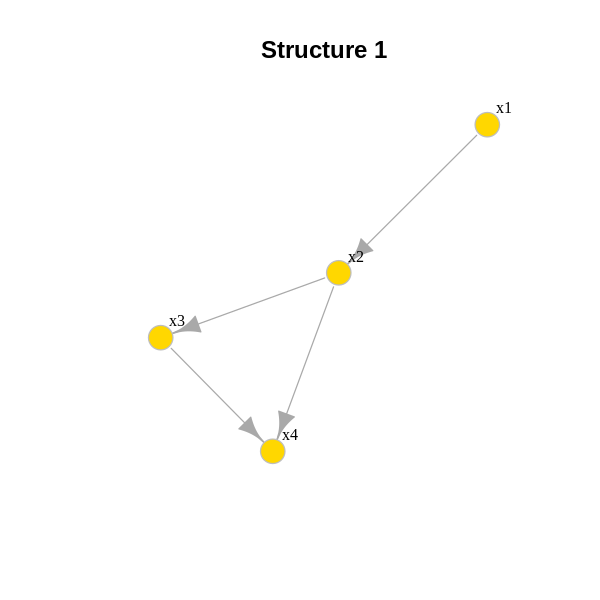

In [52]:
g1 <- graph( edges )

to_add<-NULL
for (i in c(1:(n))){
    if (!(colnames(df)[i] %in% edges))
        {
        to_add<-c(to_add, (colnames(df)[i]))
        }
}

g1<-add_vertices( g1, length(to_add), names=to_add )

plot(g1, main="Structure 1",edge.arrow.size=1.75, vertex.color="gold", vertex.size=15, 
     vertex.frame.color="gray", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=2)

### A possible modification for large datasets <a class="anchor" id="stirling"></a>

In the case of large datasets, the calculation of the involved factorials can pose computational problems which make the usefulness of the k2 algorithm wane; after $n=270$, R becomes less and less performant. Such a number is easily reached for $N_{ij}$, and also $N_{ijk}$. 
A possible countermeasure stands in using Stirling's approximation.Taking the logarithm of the formulae described above, one can transform the products into sums, and then turn the logarithms of factorials into much simpler logarithms:
$$
\log n! \approx n \log n - n
$$
This would make the application of the algorithm feasible also for larger datasets, where the number of entries is very large.

[Back to ToC](#toc)